In [38]:
import torchvision.models as models
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import numpy as np

#model = models.quantization.mobilenet_v2(pretrained=True, quantize=True)
model = models.resnet18(pretrained=True)
#model = models.mobilenet_v3_small(pretrained=True)
#model = models.squeezenet1_1(pretrained=True)

#model = models.quantization.mobilenet_v3_large(pretrained=True, quantize=False)
model.eval()

quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)
quantized_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
import os

def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 46.834317
Size (MB): 45.299081


In [19]:
labels = [line.strip() for line in open("imagenet_labels.txt")]
transform = transforms.Compose([transforms.Resize(255),
                              transforms.CenterCrop(224),
                               transforms.ToTensor()])

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])

image = Image.open("image.jpg").convert('RGB')
image = transform(image)
image = normalize(image)
image = image.unsqueeze(0)


out = model(image)
label = labels[torch.argmax(out[0]).item()]
print(f"Found a {label}")


Found a 'bluetick'


batch size =  1
iter 0, time =  0.09766390400000091
iter 1, time =  0.1076030039998841
iter 2, time =  0.0986823939997521
iter 3, time =  0.1008069780000369
iter 4, time =  0.09900474000005488
iter 5, time =  0.10111501700021108
iter 6, time =  0.09798227600003884
iter 7, time =  0.09362571799965735
iter 8, time =  0.10169271799986745
iter 9, time =  0.10577429699969798
mean latency = 0.1004
std latency = 0.0038
batch size =  2
iter 0, time =  0.19334257299988167
iter 1, time =  0.17124579000028461
iter 2, time =  0.18335329499996078
iter 3, time =  0.1707073330003368
iter 4, time =  0.1816213609999977
iter 5, time =  0.16769423699997787
iter 6, time =  0.1743207579997943
iter 7, time =  0.17647176099990247
iter 8, time =  0.17554722399972889
iter 9, time =  0.1693205990000024
mean latency = 0.1764
std latency = 0.0074
batch size =  4
iter 0, time =  0.3181439630002387
iter 1, time =  0.3242606329999944
iter 2, time =  0.3452618530000109
iter 3, time =  0.3263872789998459
iter 4, time 

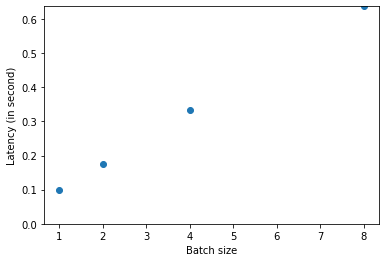

In [40]:
# Count Latency with different batch size:
input_size = 224
batch_size = [1, 2, 4, 8]
#batch_size = [1]
latency_batch = []

for batch_s in batch_size:
    input_data = torch.rand(batch_s, 3, input_size, input_size)
    latencies =[]
    print("batch size = ", batch_s)
    
    with torch.no_grad():
        for i in range(11):
            start = timer()
            output = quantized_model(input_data)
            end = timer()

            if (i > 0):
                latencies.append(end - start)
                print("iter {}, time = ".format(i-1), latencies[-1])
    latency_batch.append(np.mean(latencies))
    print("mean latency = {:.4f}".format(np.mean(latencies)))
    print("std latency = {:.4f}".format(np.std(latencies)))

plt.plot(batch_size, latency_batch, 'o')
plt.xlabel('Batch size')
plt.ylabel('Latency (in second)')
plt.ylim(0, np.max(latency_batch))
plt.savefig("resnet_batch_latency.png")